In [64]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Raw file

In [65]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


**Create the module**

In [66]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [67]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [75]:
batch_size = 30
iris_data_file = 'data/iris.data.txt'

In [76]:
# Get the datasets
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [77]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

In [78]:
num_epochs = 200

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()


    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.data[0])

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    
    for i, (titems, tclasses) in enumerate(test_loader):
        # How did we do on the test set (the unseen set)
        # Record the correct predictions for test data
        test_items = torch.FloatTensor(titems)
        test_classes = torch.LongTensor(tclasses)

        outputs = net(Variable(test_items))
        loss = criterion(outputs, Variable(test_classes))
        test_loss.append(loss.data[0])
        _, predicted = torch.max(outputs.data, 1)
        total = test_classes.size(0)
        correct = (predicted == test_classes).sum()
        test_accuracy.append((100 * correct / total))
    
    print ('Epoch %d/%d, TrLoss: %.4f, TeLoss: %.4f, TrAccu: %.4f, TeAccu: %.4f' %(epoch+1, num_epochs, train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1] ))


Epoch 1/200, TrLoss: 1.1113, TeLoss: 1.0580, TrAccu: 33.3333, TeAccu: 33.3333
Epoch 2/200, TrLoss: 1.0067, TeLoss: 1.0048, TrAccu: 55.0000, TeAccu: 63.3333
Epoch 3/200, TrLoss: 0.9639, TeLoss: 0.9749, TrAccu: 62.5000, TeAccu: 50.0000
Epoch 4/200, TrLoss: 0.9537, TeLoss: 0.9453, TrAccu: 51.6667, TeAccu: 60.0000
Epoch 5/200, TrLoss: 0.9158, TeLoss: 0.9132, TrAccu: 64.1667, TeAccu: 70.0000
Epoch 6/200, TrLoss: 0.8964, TeLoss: 0.8831, TrAccu: 65.8333, TeAccu: 70.0000
Epoch 7/200, TrLoss: 0.8705, TeLoss: 0.8516, TrAccu: 65.8333, TeAccu: 70.0000
Epoch 8/200, TrLoss: 0.8565, TeLoss: 0.8221, TrAccu: 65.8333, TeAccu: 70.0000
Epoch 9/200, TrLoss: 0.7956, TeLoss: 0.7937, TrAccu: 65.8333, TeAccu: 70.0000
Epoch 10/200, TrLoss: 0.7780, TeLoss: 0.7657, TrAccu: 66.6667, TeAccu: 73.3333
Epoch 11/200, TrLoss: 0.7425, TeLoss: 0.7393, TrAccu: 70.8333, TeAccu: 80.0000
Epoch 12/200, TrLoss: 0.7469, TeLoss: 0.7109, TrAccu: 76.6667, TeAccu: 86.6667
Epoch 13/200, TrLoss: 0.7099, TeLoss: 0.6862, TrAccu: 81.6667

Epoch 105/200, TrLoss: 0.2014, TeLoss: 0.2165, TrAccu: 96.6667, TeAccu: 96.6667
Epoch 106/200, TrLoss: 0.1373, TeLoss: 0.2043, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 107/200, TrLoss: 0.1217, TeLoss: 0.2052, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 108/200, TrLoss: 0.1719, TeLoss: 0.2059, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 109/200, TrLoss: 0.1820, TeLoss: 0.2040, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 110/200, TrLoss: 0.1166, TeLoss: 0.2075, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 111/200, TrLoss: 0.1195, TeLoss: 0.2042, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 112/200, TrLoss: 0.1346, TeLoss: 0.2016, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 113/200, TrLoss: 0.1938, TeLoss: 0.2025, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 114/200, TrLoss: 0.2075, TeLoss: 0.2025, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 115/200, TrLoss: 0.1947, TeLoss: 0.2030, TrAccu: 97.5000, TeAccu: 96.6667
Epoch 116/200, TrLoss: 0.1839, TeLoss: 0.2057, TrAccu: 96.6667, TeAccu: 96.6667
Epoch 117/200, TrLoss: 0.2078, TeLoss: 0

Plot loss vs iterations

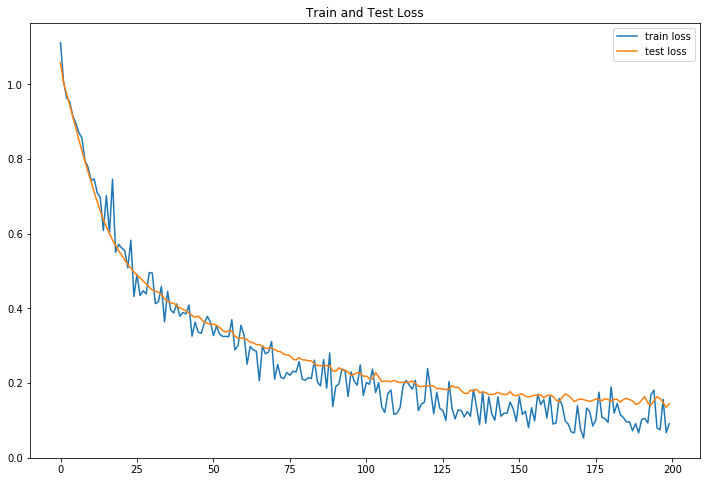

In [79]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

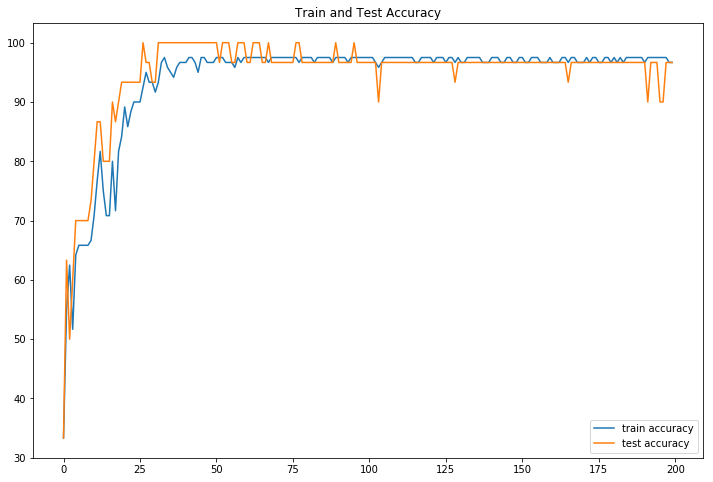

In [80]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

### Savign the model to disk, and loading it back

In [21]:
torch.save(net.state_dict(), "./2.model.pth")

In [22]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

In [23]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [24]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0
